# Classificação de imagens usando rede neural convolucional (CNN) - MNIST

O conjunto de dados MNIST (Modified National Institute of Standards and Technology database) é um grande conjunto de dados de dígitos manuscritos comumente usado na área de aprendizado de máquina. Ele consiste de 60.000 imagens de treinamento e 10.000 images de teste. As imagens do conjunto são de 28x28 pixels. Uma descrição completa do conjunto de dados pode ser encontrada [aqui](https://en.wikipedia.org/wiki/MNIST_database).

Uma das principais vantagens das redes neurais convolucionais (CNNs) é que elas usualmente possuem menos parâmetros que precisam ser aprendidos. O objetivo principal deste notebook é:
- ilustrar o uso de uma rede neural para uma tarefa de classificação de imagens.


In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import keras
import numpy as np
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Conv2D, Dense, Dropout, Input
from keras.layers import MaxPooling2D, Flatten
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import sys


## Carregando os conjuntos de treino e de teste

In [2]:
#Loading the data using keras utility
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Printing the shape of the train and test sets
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## Mostrando o conjunto de treino

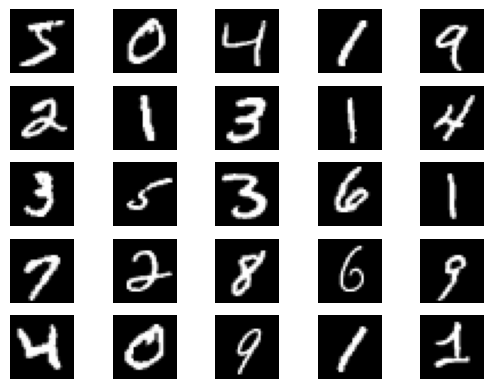

In [3]:
#Displaying a few samples of the train set
fig, ax = plt.subplots(nrows=5, ncols=5)
counter = 0
for row in ax:
    for col in row:
        col.imshow(x_train[counter], cmap = 'gray')
        col.axis("off")
        counter+=1
plt.show()

## Mostrando o conjunto de teste

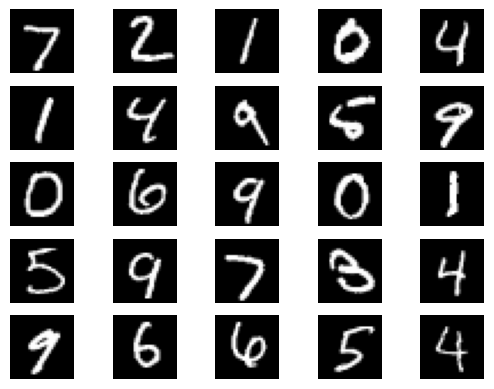

In [4]:
#Displaying a few samples of the test set
fig, ax = plt.subplots(nrows=5, ncols=5)
counter = 0
for row in ax:
    for col in row:
        col.imshow(x_test[counter], cmap = 'gray')
        col.axis("off")
        counter+=1
plt.show()

## Normalizando os dados


In [5]:
#Setting training parameters
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
    
#Normalizing data between 0 and 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
# One hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

*1. Assim como no Notebook anterior, temos nesse trecho do código a função reshape. Mas aqui ela está sendo usada com outros parâmetros. Qual a diferença e porque?*

RESP: A função reshape está sendo usada para adicionar uma dimensão extra (.., 1) à matriz de entrada para informar a quantidade de canais na imagem, dado necessário para as funções do Keras que definem redes convolucionais.

## Definindo a CNN

In [6]:
def my_model(input_shape):
    input_signal = Input(input_shape)
    conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu',
                 input_shape=input_shape)(input_signal)
    conv2 = Conv2D(64,kernel_size=(3,3),activation="relu")(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv2)
    drop1 = Dropout(0.25)(pool1)
    flat1 = Flatten()(drop1)
    prediction = Dense(10,activation = 'softmax')(flat1)
    model = Model(inputs=input_signal, outputs=prediction)
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
    return model

*2. Qual o tipo de modelo (rede) está sendo construída nesse caso: rede neural convencional ou rede neural convolucional? Como você chegou na esta conclusão? Quantas camadas ela possui e para que serve cada uma delas?*

RESP: Rede neural convolucional, devido às funções Conv2D() acima. Temos 5 camadas neste modelo:

- Camada Convolucional de entrada: Recebe os dados de entrada (imagens) e busca extrair *features* de baixa complexidade (curvas, linhas, etc.). Esta camada conta com filtros de dimensão 3x3 e tem uma camada de ativação não linear do tipo ReLU.
- Camada Convolucional intermediária: Esta segunda camada recebe como entrada a saída da camada convolucional anterior e busca extrair *features* de mais alta complexidade (regiões, etc). Esta camada conta com filtros também de dimensão 3x3 e com o mesmo tipo de camada de ativação.
- Camada de MaxPooling: Após as duas camadas de ativação, uma camada de MaxPooling efetua a sumarização das imagens geradas pelas camadas anteriores, neste caso com uma dimensão de 2x2. Essa camada utiliza na saída uma camada de ativação do tipo dropout, que elimina alguns neurônios das camadas anteriores para melhorar a acurácia do modelo.
- Camada de "Achatamento": Esta camada é utilizada para agregar os dados das imagens em uma estrutura linear.
- Camada densa de saída: Finalmente, a última camada é uma camada densa tradicional para entragar na saída a classificação desejada nas 10 classes de números. Conta com uma camada de ativação do tipo Softmax que é normalmente usada em tarefas de classificação.

## Resumo do modelo

In [7]:
#Building the model and showing a summary
model = my_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                             

*3(a). Tente entender as dimensões da saída de cada camada da rede. Por exemplo, porque a primeira camada tem a saída com dimensões (None, 28, 28, 1) e a segunda camada (None, 26, 26, 32)?*

RESP: A primeira camada tem a saída com essas dimensões (None, 28, 28, 1) devido á resolução das imagens (28x28) e a quantidade de canais das imagens (1, tons de cinza), enquanto que a segunda camada tem as dimensões (None, 26, 26, 32) pois a saída da primeira camada gera imagens de dimensão 26x26 (devido ao tamanho do filtro 3x3) e a quantidade de canais (32).

*3(b). E quanto aos parâmetros a serem aprendidos, você consegue explicar como eles são calculados? Em comparação com a rede no NB Ex05a, essa rede tem mais ou menos parâmetros a serem treinados?*

RESP: O meu entendimento é que os parâmetros em uma CNN são calculados verificando padrões de intensidades de pixels nas regiões em que os filtros convolucionais são aplicados, para cada uma dos canais resultantes do processo de convolução.

Em comparação com a rede do ex05a, esta rede tem menos parâmetros a serem treinados, justamente pelo fato das redes convolucionais usarem filtros bidimensionais.

## Treinando o modelo

In [8]:
# Checkpoint callback to save model after each improvement along the epochs
checkpoint = ModelCheckpoint('mnist_keras_cnn.model', monitor='val_loss'
                             ,verbose=0,save_weights_only= True,
                             save_best_only=True)

#Training the model
print(x_train.shape)
print(y_train.shape)
epochs = 4
model_history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split= 0.2,callbacks = [checkpoint])

(60000, 28, 28, 1)
(60000, 10)
Epoch 1/4
375/375 [==============================] - 11s 17ms/step - loss: 2.2963 - accuracy: 0.1015 - val_loss: 2.2765 - val_accuracy: 0.1382
Epoch 2/4
375/375 [==============================] - 3s 8ms/step - loss: 2.2622 - accuracy: 0.1668 - val_loss: 2.2397 - val_accuracy: 0.2424
Epoch 3/4
375/375 [==============================] - 3s 8ms/step - loss: 2.2236 - accuracy: 0.2572 - val_loss: 2.1968 - val_accuracy: 0.3202
Epoch 4/4
375/375 [==============================] - 3s 9ms/step - loss: 2.1775 - accuracy: 0.3469 - val_loss: 2.1443 - val_accuracy: 0.4447


## Curva de treino e validação

In [9]:
model_history.history

{'loss': [2.2962894439697266,
  2.262232780456543,
  2.223637580871582,
  2.177487373352051],
 'accuracy': [0.1014999970793724,
  0.1668333262205124,
  0.25718748569488525,
  0.34693750739097595],
 'val_loss': [2.2764923572540283,
  2.239722728729248,
  2.1968142986297607,
  2.144289493560791],
 'val_accuracy': [0.1381666660308838,
  0.24241666495800018,
  0.320166677236557,
  0.44466665387153625]}

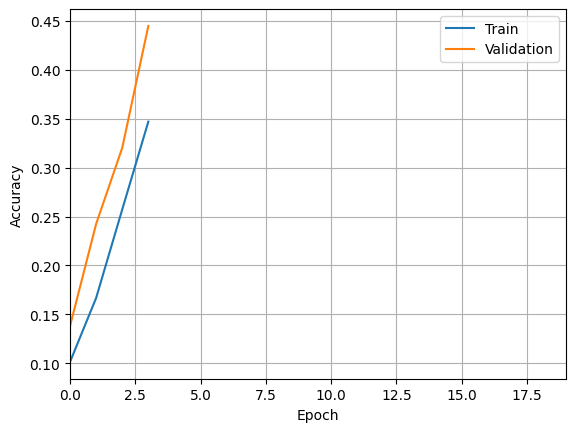

In [10]:
#Plot accuracy history
plt.plot(model_history.history['accuracy'], label = "Train")
plt.plot(model_history.history['val_accuracy'],label = "Validation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(0,19)
plt.grid()
plt.show()

## Carregando o melhor modelo e avaliando no conjunto de teste

In [11]:
#Load the best_model during training
best_model = my_model(input_shape)
best_model.load_weights('mnist_keras_cnn.model')

#Evaluate the model on the test set
score = best_model.evaluate(x_test, y_test, verbose=0)
print('Test loss: %f' %score[0])
print('Test accuracy: %f' %score[1])

Test loss: 2.146354
Test accuracy: 0.432400


## Mostrando alguns erros de predição

313/313 [==============================] - 1s 2ms/step


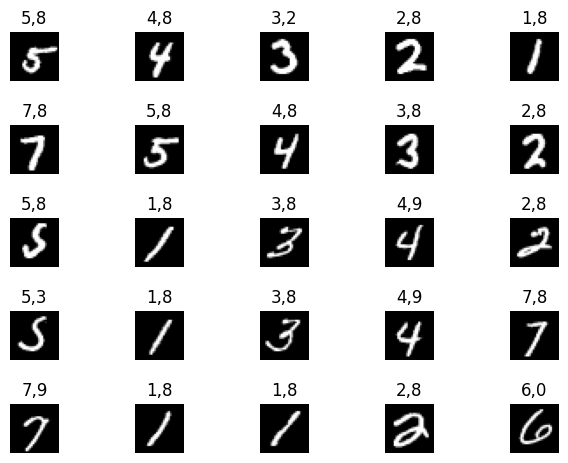

In [12]:
# Run predicition
ypred = best_model.predict(x_test).argmax(axis = 1)
y_test2 = y_test.argmax(axis = 1)

# See samples where prediction failed
indexes = np.where(ypred!=y_test2)[0][::-1]

#Display some of the errors
x_test2 = x_test.reshape(-1,28,28)
fig, ax = plt.subplots(nrows=5, ncols=5)
plt.tight_layout()
counter = 0
for row in ax:
    for col in row:
        aux = indexes[counter]
        col.imshow(x_test2[aux], cmap = 'gray')
        col.axis("off")
        col.set_title("%d,%d" %(y_test2[aux],ypred[aux]))
        counter+=1
plt.show()

## Sugestão de atividade (opcional)

- Tente melhorar o resultado do modelo no conjunto de teste, aumentando o número de épocas de treinamento. Use a GPU do Colab e acompanhe a curva de erro (loss) para garantir que não haja overfitting.